# Classifier for SG and DG events. Classifier for interesting events

### Code to parse the typical STARlight output

In [1]:
import pandas as pd

def parse_starlight_output(file_path):
    events = []
    vertices = []
    tracks = []
    
    with open(file_path, 'r') as file:
        current_event = None
        current_vertex = None
        
        for line in file:
            if line.startswith("EVENT"):
                if current_event:
                    events.append(current_event)
                event_data = line.split()
                current_event = {
                    "Event Number": int(event_data[1]),
                    "Number of Tracks": int(event_data[2]),
                    "Number of Vertices": int(event_data[3]),
                    "Vertices": [],
                    "Tracks": []
                }
            elif line.startswith("VERTEX"):
                vertex_data = line.split()
                current_vertex = {
                    "x": float(vertex_data[1]),
                    "y": float(vertex_data[2]),
                    "z": float(vertex_data[3]),
                    "t": float(vertex_data[4]),
                    "Vertex Number": int(vertex_data[5]),
                    "Process Number": int(vertex_data[6]),
                    "Parent Track": int(vertex_data[7]),
                    "Number of Daughters": int(vertex_data[8])
                }
                current_event["Vertices"].append(current_vertex)
            elif line.startswith("TRACK"):
                track_data = line.split()
                track = {
                    "GPID": int(track_data[1]),
                    "px": float(track_data[2]),
                    "py": float(track_data[3]),
                    "pz": float(track_data[4]),
                    "Event Number": int(track_data[5]),
                    "Track Number": int(track_data[6]),
                    "Stop Vertex": int(track_data[7]),
                    "PDGPID": int(track_data[8])
                }
                current_event["Tracks"].append(track)
        
        if current_event:
            events.append(current_event)
    
    # Flatten the data into lists of dictionaries for DataFrame conversion
    event_list = []
    vertex_list = []
    track_list = []
    
    for event in events:
        event_list.append({
            "Event Number": event["Event Number"],
            "Number of Tracks": event["Number of Tracks"],
            "Number of Vertices": event["Number of Vertices"]
        })
        
        for vertex in event["Vertices"]:
            vertex["Event Number"] = event["Event Number"]
            vertex_list.append(vertex)
        
        for track in event["Tracks"]:
            track_list.append(track)
    
    # Convert to DataFrames
    event_df = pd.DataFrame(event_list)
    vertex_df = pd.DataFrame(vertex_list)
    track_df = pd.DataFrame(track_list)
    
    return event_df, vertex_df, track_df





### Code to compute the total Lorentz Vector of tracks belonging to the same event

In [2]:
import pandas as pd
import numpy as np
from scipy.constants import c
import vector


# Assuming the parse_starlight_output function from the previous code has been defined

def group_tracks_by_event(track_df):
    grouped_tracks = track_df.groupby('Event Number').apply(lambda x: x.to_dict(orient='records'), include_groups=False).to_dict()
    return grouped_tracks

def create_lorentz_vector(px, py, pz, mass):
    vec = vector.obj(px=px, py=py, pz=pz, E=(px**2 + py**2 + pz**2 + mass**2)**0.5)
    return vec

def get_mass_from_pdgid(pdgid):
    """
    Returns the mass in GeV/c^2 based on the PDG ID code.

    Parameters:
    pdgid (int): PDG ID code of the particle.

    Returns:
    float: Mass of the particle in GeV/c^2.
    """
    pdg_masses = {
        11: 0.000511,   # Electron mass in GeV/c^2
        13: 0.10566,    # Muon mass in GeV/c^2
        211: 0.13957,   # Charged Pion (pi+) mass in GeV/c^2
        3122: 1.11568,  # Lambda (Λ) mass in GeV/c^2
        111: 0.134977,  # Neutral Pion (pi0) mass in GeV/c^2
        2112: 0.939565, # Neutron (n) mass in GeV/c^2
        2212: 0.938272, # Proton (p) mass in GeV/c^2
        321: 0.493677,  # Charged Kaon (K+) mass in GeV/c^2
        22: 0.0,        # Photon (γ) mass in GeV/c^2 (massless)
        310: 0.497611,  # Neutral Kaon (K0_S) mass in GeV/c^2
    }
    return pdg_masses.get(abs(pdgid), 0)  # Default to 0 if mass is unknown


def perform_operations_on_event(grouped_tracks):
    """
    Creates a DataFrame with all Lorentz vectors for each event using the vector package.

    Parameters:
    grouped_tracks (dict): A dictionary where keys are event numbers and values are lists of track dictionaries.

    Returns:
    DataFrame: A DataFrame with columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    daughters_list = []
    mothers_list = []

    for event_number, event_tracks in grouped_tracks.items():
        mother = create_lorentz_vector(0., 0., 0., 0.)
        for track in event_tracks:
            mass = get_mass_from_pdgid(track['PDGPID'])
            vec = create_lorentz_vector(track['px'], track['py'], track['pz'], mass)
            daughters_list.append({
                'Event Number': event_number,
                'Track Number': track['Track Number'],
                'Energy': vec.E,
                'px': vec.px,
                'py': vec.py,
                'pz': vec.pz
            })
            mother += vec
        mothers_list.append({
            'mother': mother,
            'Energy': mother.E,
            'px': mother.px,
            'py': mother.py,
            'pz': mother.pz
        })

    # Create DataFrame
    daughters_df = pd.DataFrame(daughters_list)
    mothers_df = pd.DataFrame(mothers_list)

    return daughters_df, mothers_df

# Example usage:
# event_df, vertex_df, track_df = parse_starlight_output('starlight_output.txt')
# grouped_tracks = group_tracks_by_event(track_df)
# total_vector = perform_operations_on_event(grouped_tracks, 1)
# print(total_vector)

# The total_vector will be an array [E_total, px_total, py_total, pz_total]


# Example usage:
# Assuming grouped_tracks is the output from the previous grouping process
# lorentz_vectors_df = perform_operations_on_event(grouped_tracks)

# Display the DataFrame
# print(lorentz_vectors_df.head())



In [3]:
event_df_jpsi, vertex_df_jpsi, track_df_jpsi = parse_starlight_output('slight-jpsi.out')
grouped_tracks_jpsi = group_tracks_by_event(track_df_jpsi)
daughters_jpsi_df, jpsi_df = perform_operations_on_event(grouped_tracks_jpsi)
print(jpsi_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=0.011639999999999873, py=0...  3.112226  0.011640   
1  MomentumObject4D(px=-0.07320800000000005, py=0...  3.129026 -0.073208   
2  MomentumObject4D(px=0.021910000000000096, py=0...  3.188167  0.021910   
3  MomentumObject4D(px=0.0959000000000001, py=-0....  3.472467  0.095900   
4  MomentumObject4D(px=0.015509999999999913, py=0...  3.429295  0.015510   

         py        pz  
0  0.028130 -0.306978  
1  0.011015  0.440825  
2  0.034106  0.756536  
3 -0.014874 -1.566923  
4  0.063889  1.471354  


In [4]:
event_df_gg, vertex_df_gg, track_df_gg = parse_starlight_output('slight-gg.out')
grouped_tracks_gg = group_tracks_by_event(track_df_gg)
daughters_gg_df, gg_df = perform_operations_on_event(grouped_tracks_gg)
print(gg_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=0.002374000000000015, py=0...  2.605134  0.002374   
1  MomentumObject4D(px=-0.03393200000000002, py=-...  1.011372 -0.033932   
2  MomentumObject4D(px=0.03916300000000006, py=-0...  1.638124  0.039163   
3  MomentumObject4D(px=-0.048740000000000006, py=...  2.768532 -0.048740   
4  MomentumObject4D(px=0.00892900000000002, py=-0...  1.453469  0.008929   

         py        pz  
0  0.000150  1.883961  
1 -0.068489 -0.083270  
2 -0.023573 -0.099818  
3 -0.008025 -0.626137  
4 -0.014635 -0.436247  


### Make the dissociative distribution

In [5]:

def modify_pt_distribution(df, peak_pt=0.1, scale_factor=1.0):
    """
    Creates a new DataFrame with a modified pT distribution following a lognormal shape by iterating over each row.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'mother', 'Energy', 'px', 'py', 'pz'.
    peak_pt (float): The desired peak of the lognormal pT distribution (default is 0.4 GeV).
    scale_factor (float): Factor to scale the new pT values to adjust the distribution width (default is 1.0).

    Returns:
    DataFrame: A new DataFrame with the same format as the input, but with modified pT values.
    """

    # Prepare a list to store the new rows
    new_rows = []

    # Calculate the parameters of the lognormal distribution
    sigma = 0.5  # Controls the spread of the distribution; adjust as needed
    mean = np.log(peak_pt) - sigma**2  # Ensures that the peak is at peak_pt

    for index, row in df.iterrows():
        # Extract the px, py, pz, and mass from the current mother vector
        px = row['mother'].px
        py = row['mother'].py
        pz = row['mother'].pz
        mass = row['mother'].mass

        # Calculate the current pT
        pt = np.sqrt(px**2 + py**2)

        # Generate a new pT value from the lognormal distribution
        new_pt = np.random.lognormal(mean, sigma) * scale_factor

        # Update the px and py components to reflect the new pT value while keeping the same direction
        new_px = px * (new_pt / pt)
        new_py = py * (new_pt / pt)

        # Recalculate the energy using the modified px, py, and the original pz and mass
        new_energy = np.sqrt(new_px**2 + new_py**2 + pz**2 + mass**2)

        # Create a new Lorentz vector
        new_mother = vector.obj(px=new_px, py=new_py, pz=pz, E=new_energy)

        # Append the new row data
        new_rows.append({
            'mother': new_mother,
            'Energy': new_energy,
            'px': new_px,
            'py': new_py,
            'pz': pz
        })

    # Create the new DataFrame
    new_df = pd.DataFrame(new_rows)

    return new_df

# Example usage:
# Assuming df is your original DataFrame
# modified_df = modify_pt_distribution(df)

# Display the first few rows of the modified DataFrame
# print(modified_df.head())


In [6]:
dissociative_df = modify_pt_distribution(gg_df)
print(dissociative_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=0.06489960609329284, py=0....  2.605945  0.064900   
1  MomentumObject4D(px=-0.008235533061231377, py=...  1.008651 -0.008236   
2  MomentumObject4D(px=0.04793304578078852, py=-0...  1.638441  0.047933   
3  MomentumObject4D(px=-0.08304566575589867, py=-...  2.769371 -0.083046   
4  MomentumObject4D(px=0.02429807923279227, py=-0...  1.454116  0.024298   

         py        pz  
0  0.004101  1.883961  
1 -0.016623 -0.083270  
2 -0.028852 -0.099818  
3 -0.013673 -0.626137  
4 -0.039826 -0.436247  


### Utility functions for visualisation

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mass_and_pt_distribution(df):
    """
    Plots the mass distribution and transverse momentum distribution from a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'mother', 'Energy', 'px', 'py', 'pz'.
    """

    # Calculate the mass and transverse momentum (p_T) for each row
    df['mass'] = df['mother'].apply(lambda v: v.mass)
    df['pt'] = df['mother'].apply(lambda v: v.pt)

    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the mass distribution
    ax[0].hist(df['mass'], bins=50, color='blue', alpha=0.7)
    ax[0].set_title('Mass Distribution')
    ax[0].set_xlabel('Mass (GeV/c^2)')
    ax[0].set_ylabel('Frequency')

    # Plot the transverse momentum distribution
    ax[1].hist(df['pt'], bins=50, color='green', alpha=0.7)
    ax[1].set_title('Transverse Momentum Distribution')
    ax[1].set_xlabel('p_T (GeV/c)')
    ax[1].set_ylabel('Frequency')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your input DataFrame with a 'mother' column containing vector objects
# plot_mass_and_pt_distribution(df)


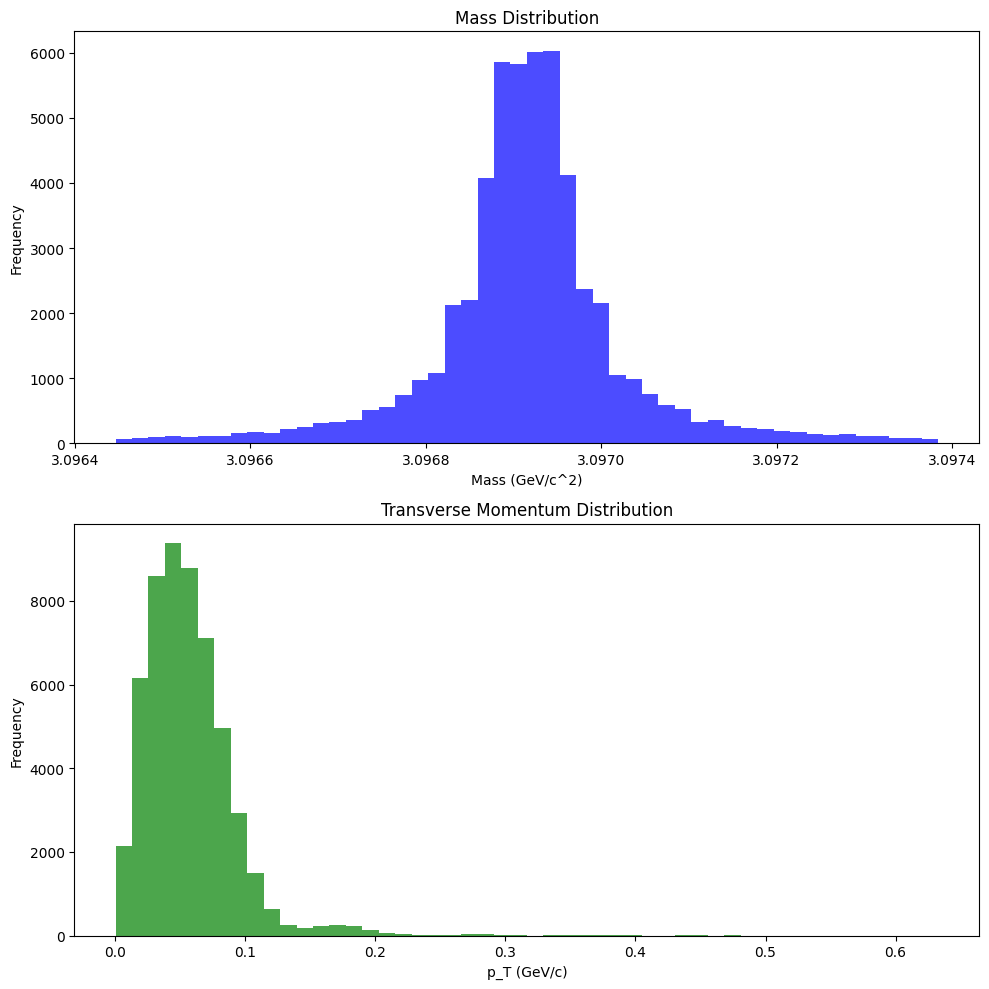

In [8]:
plot_mass_and_pt_distribution(jpsi_df)


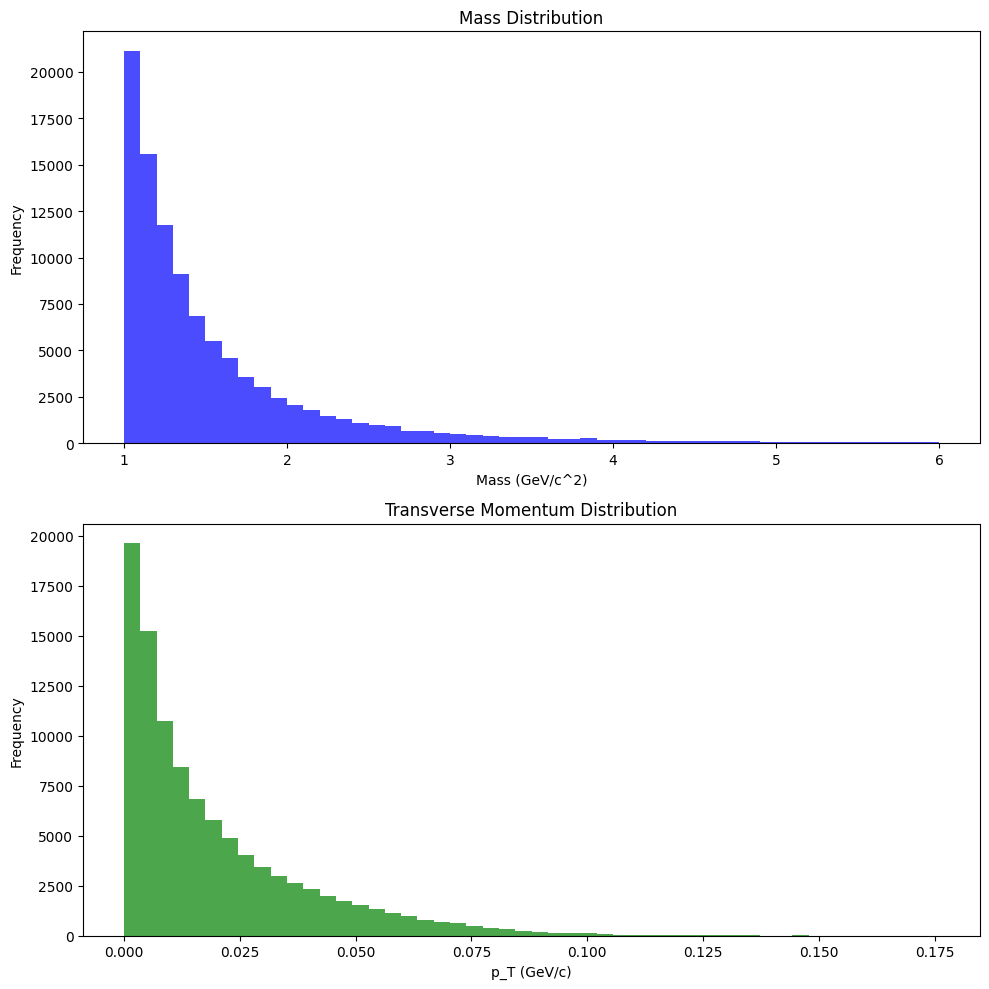

In [9]:
plot_mass_and_pt_distribution(gg_df)


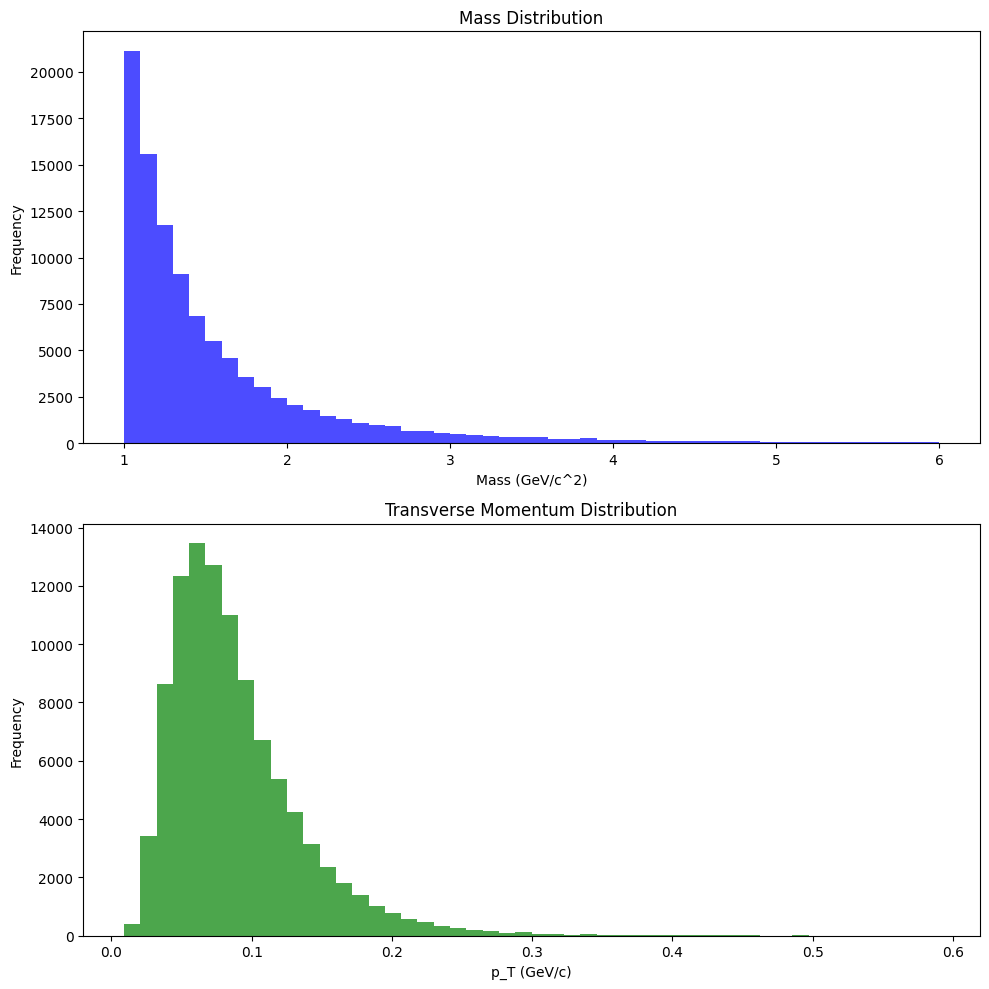

In [10]:
plot_mass_and_pt_distribution(dissociative_df)


## Machine Learning algorithm

In [11]:
jpsi_df

,mother,Energy,px,py,pz,mass,pt
0,"MomentumObject4D(px=0.011639999999999873, py=0...",3.112226,0.011640,0.028130,-0.306978,3.096900,0.030443
1,"MomentumObject4D(px=-0.07320800000000005, py=0...",3.129026,-0.073208,0.011015,0.440825,3.096934,0.074032
2,"MomentumObject4D(px=0.021910000000000096, py=0...",3.188167,0.021910,0.034106,0.756536,3.096841,0.040537
3,"MomentumObject4D(px=0.0959000000000001, py=-0....",3.472467,0.095900,-0.014874,-1.566923,3.097315,0.097047
4,"MomentumObject4D(px=0.015509999999999913, py=0...",3.429295,0.015510,0.063889,1.471354,3.096911,0.065745
...,...,...,...,...,...,...,...
53758,"MomentumObject4D(px=-0.012521000000000004, py=...",3.101571,-0.012521,-0.040940,0.164152,3.096928,0.042812
53759,"MomentumObject4D(px=0.05081000000000002, py=0....",3.212923,0.050810,0.094214,0.848714,3.096950,0.107042
53760,"MomentumObject4D(px=-0.07203100000000007, py=0...",3.269394,-0.072031,0.032520,-1.045054,3.096862,0.079032
53761,"MomentumObject4D(px=0.0206599999999999, py=0.0...",3.107490,0.020660,0.053609,0.249089,3.096958,0.057452


In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Function to label and combine simulated datasets
def prepare_simulated_data(jpsi_df, gg_df, dissociative_df):
    """
    Labels and combines the three simulated datasets.

    Parameters:
    jpsi_df (DataFrame): DataFrame containing J/psi production data.
    gg_df (DataFrame): DataFrame containing photon+photon production data.
    dissociative_df (DataFrame): DataFrame containing dissociative production data.

    Returns:
    DataFrame: Combined and labeled simulated data.
    """
    # Assign labels to the simulation data
    jpsi_df['label'] = 0
    gg_df['label'] = 1
    dissociative_df['label'] = 2

    # Combine the simulated datasets
    simulated_data = pd.concat([jpsi_df, gg_df, dissociative_df], ignore_index=True)
    return simulated_data

# Function to split and standardize data
def split_and_standardize_data(X, y):
    """
    Splits the data into training and testing sets and standardizes the features.

    Parameters:
    X (DataFrame): Features to be used in the model.
    y (Series): Target labels.

    Returns:
    tuple: Standardized training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler

# Function to train the model
def train_model(X_train, y_train):
    """
    Trains a RandomForestClassifier on the training data.

    Parameters:
    X_train (array): Standardized training features.
    y_train (Series): Training labels.

    Returns:
    model (RandomForestClassifier): Trained model.
    """
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on the test data and prints the classification report and confusion matrix.

    Parameters:
    model (RandomForestClassifier): Trained model.
    X_test (array): Standardized testing features.
    y_test (Series): Testing labels.
    """
    y_pred = model.predict(X_test)
    print("Classification Report on Simulated Data:\n", classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Simulated Data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Function to create a "real" dataset
def create_real_data(jpsi_df, gg_df, dissociative_df):
    """
    Creates a "real" dataset by combining the three simulated datasets without labels.

    Parameters:
    jpsi_df (DataFrame): DataFrame containing J/psi production data.
    gg_df (DataFrame): DataFrame containing photon+photon production data.
    dissociative_df (DataFrame): DataFrame containing dissociative production data.

    Returns:
    DataFrame: Combined "real" data.
    """
    real_data = pd.concat([jpsi_df[['mass', 'pt']], gg_df[['mass', 'pt']], dissociative_df[['mass', 'pt']]], ignore_index=True)
    return real_data

# Function to apply the model to real data
def apply_model_to_real_data(model, real_data, scaler):
    """
    Applies the trained model to the "real" data and returns the predictions and probabilities.

    Parameters:
    model (RandomForestClassifier): Trained model.
    real_data (DataFrame): "Real" data without labels.
    scaler (StandardScaler): Scaler fitted on the simulated data.

    Returns:
    DataFrame: Real data with added predictions and probabilities.
    """
    X_real = scaler.transform(real_data[['mass', 'pt']])
    real_predictions = model.predict(X_real)
    real_probabilities = model.predict_proba(X_real)

    real_data['predicted_label'] = real_predictions
    real_data['prob_jpsi'] = real_probabilities[:, 0]
    real_data['prob_photon_photon'] = real_probabilities[:, 1]
    real_data['prob_dissociative'] = real_probabilities[:, 2]

    return real_data

# Function to visualize and analyze the "real" data predictions
def analyze_real_data(real_data):
    """
    Visualizes the transverse momentum distribution and identifies dissociation candidates.

    Parameters:
    real_data (DataFrame): Real data with predictions and probabilities.
    """
    sns.histplot(real_data, x='pt', hue='predicted_label', element='step', stat='density', common_norm=False)
    plt.title('Transverse Momentum Distribution by Predicted Class')
    plt.xlabel('Transverse Momentum (GeV/c)')
    plt.ylabel('Density')
    plt.show()

    # Additional Analysis for Dissociation Events
    high_pt_threshold = real_data['pt'].quantile(0.95)  # Top 5% pt threshold
    dissociation_candidates = real_data[real_data['pt'] > high_pt_threshold]

    print("Number of Dissociation Candidates:", len(dissociation_candidates))
    print(dissociation_candidates.head())

# Function to plot feature importances
def plot_feature_importances(model):
    """
    Plots the feature importances from the trained model.

    Parameters:
    model (RandomForestClassifier): Trained model.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = ['invariant_mass', 'pt']

    plt.figure()
    plt.title("Feature Importances")
    plt.bar(range(len(features)), importances[indices], align="center")
    plt.xticks(range(len(features)), [features[i] for i in indices])
    plt.xlim([-1, len(features)])
    plt.show()


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Function to label and combine simulated datasets
def prepare_simulated_data(jpsi_df, gg_df, dissociative_df):
    """
    Labels and combines the three simulated datasets.

    Parameters:
    jpsi_df (DataFrame): DataFrame containing J/psi production data.
    gg_df (DataFrame): DataFrame containing photon+photon production data.
    dissociative_df (DataFrame): DataFrame containing dissociative production data.

    Returns:
    DataFrame: Combined and labeled simulated data.
    """
    # Assign labels to the simulation data
    jpsi_df['label'] = 0
    gg_df['label'] = 1
    dissociative_df['label'] = 2

    # Combine the simulated datasets
    simulated_data = pd.concat([jpsi_df, gg_df, dissociative_df], ignore_index=True)
    return simulated_data

# Function to split and standardize data
def split_and_standardize_data(X, y):
    """
    Splits the data into training and testing sets and standardizes the features.

    Parameters:
    X (DataFrame): Features to be used in the model.
    y (Series): Target labels.

    Returns:
    tuple: Standardized training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler

# Function to train the model
def train_model(X_train, y_train):
    """
    Trains a RandomForestClassifier on the training data.

    Parameters:
    X_train (array): Standardized training features.
    y_train (Series): Training labels.

    Returns:
    model (RandomForestClassifier): Trained model.
    """
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on the test data and prints the classification report and confusion matrix.

    Parameters:
    model (RandomForestClassifier): Trained model.
    X_test (array): Standardized testing features.
    y_test (Series): Testing labels.
    """
    y_pred = model.predict(X_test)
    print("Classification Report on Simulated Data:\n", classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Simulated Data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Function to create a "real" dataset
def create_real_data(jpsi_df, gg_df, dissociative_df):
    """
    Creates a "real" dataset by combining the three simulated datasets without labels.

    Parameters:
    jpsi_df (DataFrame): DataFrame containing J/psi production data.
    gg_df (DataFrame): DataFrame containing photon+photon production data.
    dissociative_df (DataFrame): DataFrame containing dissociative production data.

    Returns:
    DataFrame: Combined "real" data.
    """
    real_data = pd.concat([jpsi_df[['mass', 'pt']], gg_df[['mass', 'pt']], dissociative_df[['mass', 'pt']]], ignore_index=True)
    return real_data

# Function to apply the model to real data
def apply_model_to_real_data(model, real_data, scaler):
    """
    Applies the trained model to the "real" data and returns the predictions and probabilities.

    Parameters:
    model (RandomForestClassifier): Trained model.
    real_data (DataFrame): "Real" data without labels.
    scaler (StandardScaler): Scaler fitted on the simulated data.

    Returns:
    DataFrame: Real data with added predictions and probabilities.
    """
    X_real = scaler.transform(real_data[['mass', 'pt']])
    real_predictions = model.predict(X_real)
    real_probabilities = model.predict_proba(X_real)

    real_data['predicted_label'] = real_predictions
    real_data['prob_jpsi'] = real_probabilities[:, 0]
    real_data['prob_photon_photon'] = real_probabilities[:, 1]
    real_data['prob_dissociative'] = real_probabilities[:, 2]

    return real_data

# Function to visualize and analyze the "real" data predictions
def analyze_real_data(real_data):
    """
    Visualizes the transverse momentum distribution and identifies dissociation candidates.

    Parameters:
    real_data (DataFrame): Real data with predictions and probabilities.
    """
    sns.histplot(real_data, x='pt', hue='predicted_label', element='step', stat='density', common_norm=False)
    plt.title('Transverse Momentum Distribution by Predicted Class')
    plt.xlabel('Transverse Momentum (GeV/c)')
    plt.ylabel('Density')
    plt.show()

    # Additional Analysis for Dissociation Events
    high_pt_threshold = real_data['pt'].quantile(0.95)  # Top 5% pt threshold
    dissociation_candidates = real_data[real_data['pt'] > high_pt_threshold]

    print("Number of Dissociation Candidates:", len(dissociation_candidates))
    print(dissociation_candidates.head())

# Function to plot feature importances
def plot_feature_importances(model):
    """
    Plots the feature importances from the trained model.

    Parameters:
    model (RandomForestClassifier): Trained model.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = ['invariant_mass', 'pt']

    plt.figure()
    plt.title("Feature Importances")
    plt.bar(range(len(features)), importances[indices], align="center")
    plt.xticks(range(len(features)), [features[i] for i in indices])
    plt.xlim([-1, len(features)])
    plt.show()


In [14]:
# Example Usage:
# Prepare the simulated data
simulated_data = prepare_simulated_data(jpsi_df, gg_df, dissociative_df)


In [15]:
# Split and standardize the data
X_train_sim, X_test_sim, y_train_sim, y_test_sim, scaler = split_and_standardize_data(simulated_data[['mass', 'pt']], simulated_data['label'])


In [16]:
# Train the model
model = train_model(X_train_sim, y_train_sim)


Classification Report on Simulated Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16095
           1       0.89      0.84      0.86     29945
           2       0.85      0.90      0.87     30089

    accuracy                           0.90     76129
   macro avg       0.91      0.91      0.91     76129
weighted avg       0.90      0.90      0.90     76129



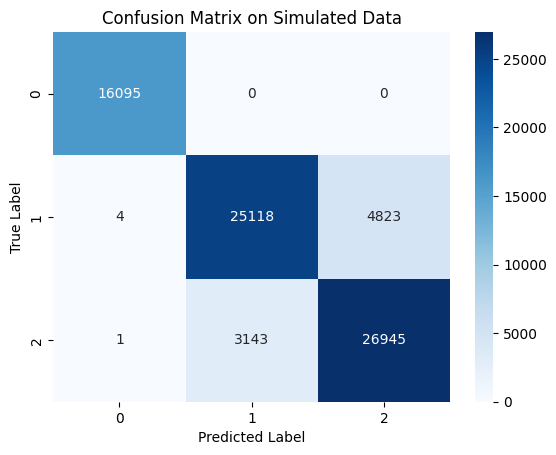

In [17]:
# Evaluate the model
evaluate_model(model, X_test_sim, y_test_sim)

In [18]:
# Create the "real" dataset
real_data = create_real_data(jpsi_df, gg_df, dissociative_df)


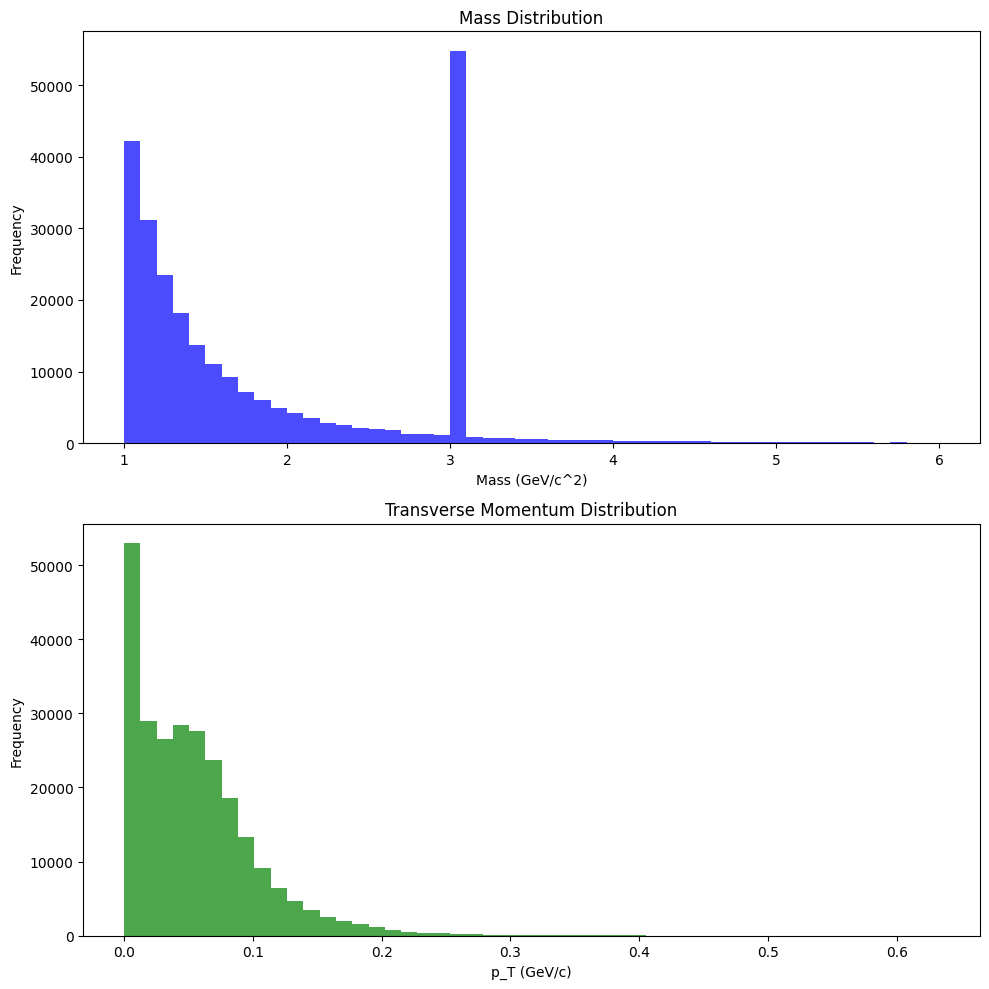

In [19]:
def plot_mass_and_pt_distribution_simple(df):
    """
    Plots the mass distribution and transverse momentum distribution from a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'mother', 'Energy', 'px', 'py', 'pz'.
    """
    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the mass distribution
    ax[0].hist(df['mass'], bins=50, color='blue', alpha=0.7)
    ax[0].set_title('Mass Distribution')
    ax[0].set_xlabel('Mass (GeV/c^2)')
    ax[0].set_ylabel('Frequency')

    # Plot the transverse momentum distribution
    ax[1].hist(df['pt'], bins=50, color='green', alpha=0.7)
    ax[1].set_title('Transverse Momentum Distribution')
    ax[1].set_xlabel('p_T (GeV/c)')
    ax[1].set_ylabel('Frequency')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()



plot_mass_and_pt_distribution_simple(real_data)


In [20]:
# Apply the model to the "real" data
real_data_with_predictions = apply_model_to_real_data(model, real_data, scaler)

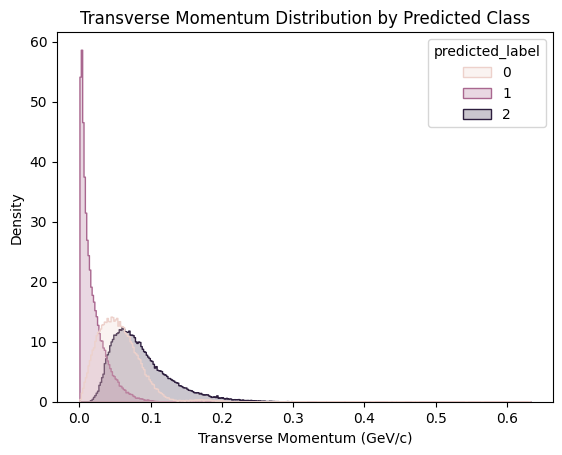

Number of Dissociation Candidates: 12689
         mass        pt  predicted_label  prob_jpsi  prob_photon_photon  \
8    3.096804  0.273207                0       1.00                 0.0   
81   3.096879  0.159063                0       1.00                 0.0   
94   3.096954  0.257030                0       1.00                 0.0   
113  3.096915  0.171263                0       0.99                 0.0   
170  3.096962  0.211018                0       1.00                 0.0   

     prob_dissociative  
8                 0.00  
81                0.00  
94                0.00  
113               0.01  
170               0.00  


In [21]:
# Analyze the "real" data predictions
analyze_real_data(real_data_with_predictions)


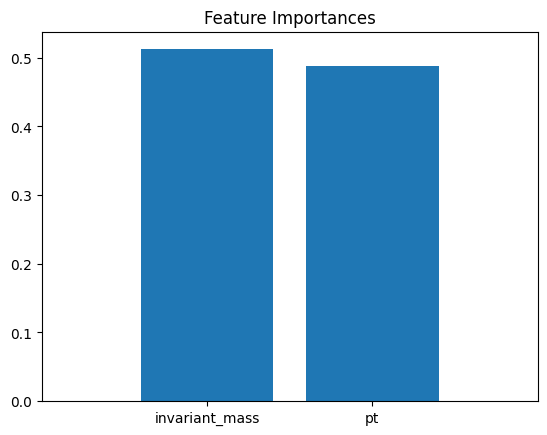

In [22]:

# Plot feature importances
plot_feature_importances(model)


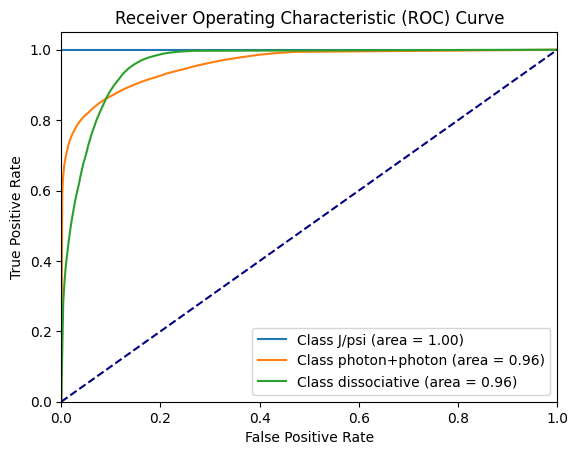

In [23]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test, class_labels):
    """
    Plots the ROC curve for a multi-class classification model.

    Parameters:
    model (RandomForestClassifier): Trained model.
    X_test (array): Test set features.
    y_test (Series): True labels for the test set.
    class_labels (list): List of class labels to plot ROC for each class.
    """

    plt.figure()

    # Iterate over each class to plot its ROC curve
    for i, class_label in enumerate(class_labels):
        y_test_binary = (y_test == i).astype(int)
        y_score = model.predict_proba(X_test)[:, i]

        fpr, tpr, _ = roc_curve(y_test_binary, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Class {class_label} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
# Assuming class_labels corresponds to ['J/psi', 'photon+photon', 'dissociative']
class_labels = ['J/psi', 'photon+photon', 'dissociative']

# Plot the ROC curve for the test set
plot_roc_curve(model, X_test_sim, y_test_sim, class_labels)


In [24]:
# Print the feature importances
print("Feature Importances:")
for feature_name, importance in zip(['invariant_mass', 'pt'], model.feature_importances_):
    print(f"{feature_name}: {importance:.4f}")

# Print the model's hyperparameters
print("\nModel Hyperparameters:")
print(model.get_params())

# Optionally, inspect individual trees in the forest
from sklearn.tree import export_text

# Print out the structure of one of the trees (e.g., the first tree in the forest)
print("\nDecision Tree Structure (First Tree in the Forest):")
tree_structure = export_text(model.estimators_[0], feature_names=['invariant_mass', 'pt'])
print(tree_structure)


Feature Importances:
invariant_mass: 0.5123
pt: 0.4877

Model Hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Decision Tree Structure (First Tree in the Forest):
|--- pt <= -0.48
|   |--- invariant_mass <= 1.37
|   |   |--- pt <= -0.66
|   |   |   |--- pt <= -0.77
|   |   |   |   |--- pt <= -0.82
|   |   |   |   |   |--- invariant_mass <= -0.98
|   |   |   |   |   |   |--- invariant_mass <= -0.98
|   |   |   |   |   |   |   |--- pt <= -0.90
|   |   |   |   |   |   |   |   |--- pt <= -0.95
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- pt >  -0.95
|   |   |   |   |   |

## Classifier for event topology

In [25]:
event_df_inclusive, vertex_df_inclusive, track_df_inclusive = parse_starlight_output('slight_k10000.out')
grouped_tracks_inclusive = group_tracks_by_event(track_df_inclusive)


In [38]:
# Code to retrieve global properties of the event
def process_starlight_data(event_df, vertex_df, track_df):
    """
    Processes STARlight simulation data, groups tracks by event, and converts them into Lorentz vectors.
    Also identifies the mother particle for each event.

    Parameters:
    event_df (DataFrame): DataFrame containing event data.
    vertex_df (DataFrame): DataFrame containing vertex data, including Parent Track information.
    track_df (DataFrame): DataFrame containing track data, including momentum components.

    Returns:
    DataFrame: A processed DataFrame where each row corresponds to an event, with tracks grouped into Lorentz vectors.
    """

    processed_events = []

    # Iterate over each unique event
    for event_number in event_df['Event Number'].unique():
        # Filter tracks and vertices for the current event
        event_tracks = track_df[track_df['Event Number'] == event_number]
        event_vertices = vertex_df[vertex_df['Event Number'] == event_number]

        # Find the mother particle (where Parent Track == 0 in the vertex dataframe)
        mother_vertex = event_vertices[event_vertices['Parent Track'] == 0]
        if mother_vertex.empty:
            continue  # Skip this event if no mother particle is found
        
        mother_vertex = mother_vertex.iloc[0]
        mother_track = event_tracks[event_tracks['Track Number'] == mother_vertex['Parent Track']]

        # Extract the Lorentz vector for the mother particle
        if not mother_track.empty:
            mother_track = mother_track.iloc[0]
            mass = get_mass_from_pdgid(mother_track['PDGPID'])
            mother_vector = create_lorentz_vector(mother_track['px'], mother_track['py'], mother_track['pz'], mass)
        else:
            mother_vector = None

        # Create Lorentz vectors for all tracks in the event
        track_vectors = []
        for _, track in event_tracks.iterrows():
            mass = get_mass_from_pdgid(track['PDGPID'])
            track_vector = create_lorentz_vector(track['px'], track['py'], track['pz'], mass)
            track_vectors.append(track_vector)

        # Append the processed event information to the list
        processed_events.append({
            'Event Number': event_number,
            'Mother': mother_vector,
            'Tracks': track_vectors
        })

    # Convert the processed events into a DataFrame
    processed_df = pd.DataFrame(processed_events)

    return processed_df

# Example usage:
# Assuming event_df, vertex_df, and track_df are DataFrames extracted from the STARlight output
# processed_df = process_starlight_data(event_df, vertex_df, track_df)

# Display the processed DataFrame
# print(processed_df.head())


In [39]:
processed_df_jpsi      = process_starlight_data(event_df_jpsi, vertex_df_jpsi, track_df_jpsi)


In [41]:
processed_df_jpsi.head()

,Event Number,Mother,Tracks
0,1,"MomentumObject4D(px=1.54409, py=0.102887, pz=-...","[MomentumObject4D(px=1.54409, py=0.102887, pz=..."
1,2,"MomentumObject4D(px=0.849749, py=-0.936002, pz...","[MomentumObject4D(px=0.849749, py=-0.936002, p..."
2,3,"MomentumObject4D(px=1.09453, py=1.02295, pz=-0...","[MomentumObject4D(px=1.09453, py=1.02295, pz=-..."
3,4,"MomentumObject4D(px=1.58448, py=-0.197791, pz=...","[MomentumObject4D(px=1.58448, py=-0.197791, pz..."
4,5,"MomentumObject4D(px=1.38625, py=0.710992, pz=0...","[MomentumObject4D(px=1.38625, py=0.710992, pz=..."


In [42]:
processed_df_gg        = process_starlight_data(event_df_gg, vertex_df_gg, track_df_gg)
processed_df_gg

,Event Number,Mother,Tracks
0,1,"MomentumObject4D(px=0.140385, py=-0.888044, pz...","[MomentumObject4D(px=0.140385, py=-0.888044, p..."
1,2,"MomentumObject4D(px=0.289636, py=-0.432667, pz...","[MomentumObject4D(px=0.289636, py=-0.432667, p..."
2,3,"MomentumObject4D(px=-0.660527, py=0.0459744, p...","[MomentumObject4D(px=-0.660527, py=0.0459744, ..."
3,4,"MomentumObject4D(px=-1.07913, py=0.833372, pz=...","[MomentumObject4D(px=-1.07913, py=0.833372, pz..."
4,5,"MomentumObject4D(px=0.425111, py=-0.520192, pz...","[MomentumObject4D(px=0.425111, py=-0.520192, p..."
...,...,...,...
99995,99996,"MomentumObject4D(px=0.199771, py=0.485631, pz=...","[MomentumObject4D(px=0.199771, py=0.485631, pz..."
99996,99997,"MomentumObject4D(px=-0.170095, py=-0.936645, p...","[MomentumObject4D(px=-0.170095, py=-0.936645, ..."
99997,99998,"MomentumObject4D(px=-0.168923, py=-0.443045, p...","[MomentumObject4D(px=-0.168923, py=-0.443045, ..."
99998,99999,"MomentumObject4D(px=-0.0844952, py=0.492944, p...","[MomentumObject4D(px=-0.0844952, py=0.492944, ..."


In [43]:
processed_df_inclusive = process_starlight_data(event_df_inclusive, vertex_df_inclusive, track_df_inclusive)


In [44]:
processed_df_inclusive

,Event Number,Mother,Tracks
0,1,"MomentumObject4D(px=0.0772389, py=-0.123942, p...","[MomentumObject4D(px=0.0772389, py=-0.123942, ..."
1,2,"MomentumObject4D(px=0.234648, py=-0.364128, pz...","[MomentumObject4D(px=0.234648, py=-0.364128, p..."
2,3,"MomentumObject4D(px=-0.287271, py=-0.614378, p...","[MomentumObject4D(px=-0.287271, py=-0.614378, ..."
3,4,"MomentumObject4D(px=0.49514, py=-1.09673, pz=-...","[MomentumObject4D(px=0.49514, py=-1.09673, pz=..."
4,5,"MomentumObject4D(px=-1.4572, py=0.379015, pz=-...","[MomentumObject4D(px=-1.4572, py=0.379015, pz=..."
...,...,...,...
49995,49996,"MomentumObject4D(px=-0.235575, py=0.732792, pz...","[MomentumObject4D(px=-0.235575, py=0.732792, p..."
49996,49997,"MomentumObject4D(px=0.143666, py=0.593332, pz=...","[MomentumObject4D(px=0.143666, py=0.593332, pz..."
49997,49998,"MomentumObject4D(px=-0.108146, py=-0.914976, p...","[MomentumObject4D(px=-0.108146, py=-0.914976, ..."
49998,49999,"MomentumObject4D(px=-0.407082, py=0.750664, pz...","[MomentumObject4D(px=-0.407082, py=0.750664, p..."


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_dataset(single_gap_df, double_gap_df):
    """
    Prepares the dataset by combining single and double gap events with appropriate labels.

    Parameters:
    single_gap_df (DataFrame): DataFrame containing events with a single gap in rapidity.
    double_gap_df (DataFrame): DataFrame containing events with two gaps in rapidity.

    Returns:
    DataFrame: Combined dataset with labels.
    """
    single_gap_df['label'] = 0  # Label for single gap events
    double_gap_df['label'] = 1  # Label for double gap events
    
    combined_df = pd.concat([single_gap_df, double_gap_df], ignore_index=True)
    return combined_df

def extract_and_aggregate_features(df):
    """
    Extracts and aggregates numerical features from the DataFrame containing Lorentz vectors for the mother particle and all tracks.

    Parameters:
    df (DataFrame): DataFrame containing Lorentz vectors in the 'Mother' and 'Tracks' columns.

    Returns:
    DataFrame: DataFrame with aggregated features for the mother particle and tracks, along with the label.
    """
    features = []

    for _, row in df.iterrows():
        mother = row['Mother']

        # Extract features from the mother Lorentz vector
        feature_dict = {
            'mother_px': mother.px,
            'mother_py': mother.py,
            'mother_pz': mother.pz,
            'mother_E': mother.E,
            'mother_pt': mother.pt,
            'mother_mass': mother.mass,
            'mother_rapidity': mother.rapidity,
            'label': row['label']  # Retain the label in the features
        }

        # Aggregate features across all tracks
        if row['Tracks']:
            all_px = [track.px for track in row['Tracks']]
            all_py = [track.py for track in row['Tracks']]
            all_pz = [track.pz for track in row['Tracks']]
            all_E = [track.E for track in row['Tracks']]
            all_pt = [track.pt for track in row['Tracks']]
            all_mass = [track.mass for track in row['Tracks']]
            all_rapidity = [track.rapidity for track in row['Tracks']]

            # Aggregate features (example: mean, sum, max)
            feature_dict.update({
                'tracks_px_mean': np.mean(all_px),
                'tracks_py_mean': np.mean(all_py),
                'tracks_pz_mean': np.mean(all_pz),
                'tracks_E_mean': np.mean(all_E),
                'tracks_pt_mean': np.mean(all_pt),
                'tracks_mass_mean': np.mean(all_mass),
                'tracks_rapidity_mean': np.mean(all_rapidity),
                'tracks_px_sum': np.sum(all_px),
                'tracks_py_sum': np.sum(all_py),
                'tracks_pz_sum': np.sum(all_pz),
                'tracks_E_sum': np.sum(all_E),
                'tracks_pt_sum': np.sum(all_pt),
                'tracks_mass_sum': np.sum(all_mass),
                'tracks_rapidity_sum': np.sum(all_rapidity),
            })

        features.append(feature_dict)

    return pd.DataFrame(features)


def split_and_scale_data(combined_df):
    """
    Splits the data into training and testing sets, and scales the features.

    Parameters:
    combined_df (DataFrame): Combined dataset with labels.

    Returns:
    tuple: Scaled training and testing sets, and the corresponding labels.
    """
    X = combined_df.drop(columns=['label'])
    y = combined_df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, scaler

def train_gradient_boosting_model(X_train, y_train):
    """
    Trains a Gradient Boosting Classifier.

    Parameters:
    X_train (DataFrame): Feature set for training.
    y_train (Series): Labels for training.

    Returns:
    GradientBoostingClassifier: Trained model.
    """
    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on the test data.

    Parameters:
    model (GradientBoostingClassifier): Trained model.
    X_test (DataFrame): Test features.
    y_test (Series): True labels for the test set.
    """
    y_pred = model.predict(X_test)
    
    print_classification_report(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(model, X_test, y_test)

def print_classification_report(y_test, y_pred):
    """
    Prints the classification report for the model predictions.

    Parameters:
    y_test (Series): True labels.
    y_pred (Series): Predicted labels by the model.
    """
    print("Classification Report:\n", classification_report(y_test, y_pred))

def plot_confusion_matrix(y_test, y_pred):
    """
    Plots the confusion matrix for the model predictions.

    Parameters:
    y_test (Series): True labels.
    y_pred (Series): Predicted labels by the model.
    """
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def plot_roc_curve(model, X_test, y_test):
    """
    Plots the ROC curve for the model.

    Parameters:
    model (GradientBoostingClassifier): Trained model.
    X_test (DataFrame): Test features.
    y_test (Series): True labels for the test set.
    """
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()



In [57]:
# Example usage:
# Assuming single_gap_df and double_gap_df are the DataFrames with single and double gap events
processed_df_doublegap = pd.concat([processed_df_jpsi, processed_df_gg], ignore_index=True)
combined_df = prepare_dataset(processed_df_inclusive, processed_df_doublegap)

# Extract numerical features before scaling
combined_df_features = extract_and_aggregate_features(combined_df)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15034
           1       1.00      1.00      1.00     46095

    accuracy                           1.00     61129
   macro avg       1.00      1.00      1.00     61129
weighted avg       1.00      1.00      1.00     61129



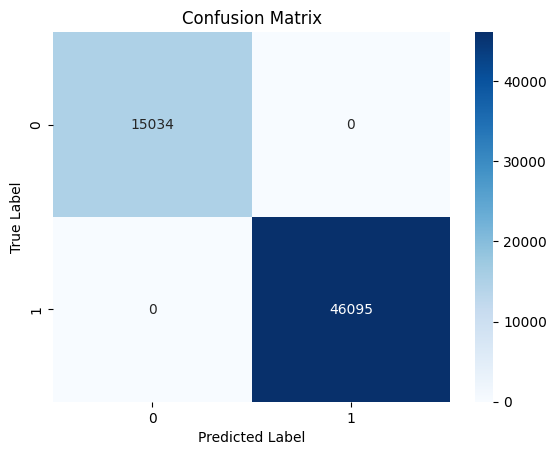

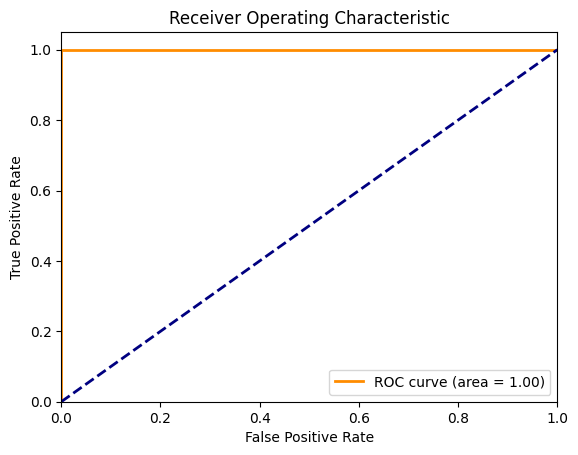

In [58]:
# Split, scale the data, and train the model
X_train, X_test, y_train, y_test, scaler = split_and_scale_data(combined_df_features)
model = train_gradient_boosting_model(X_train, y_train)

# Evaluate the model
evaluate_model(model, X_test, y_test)


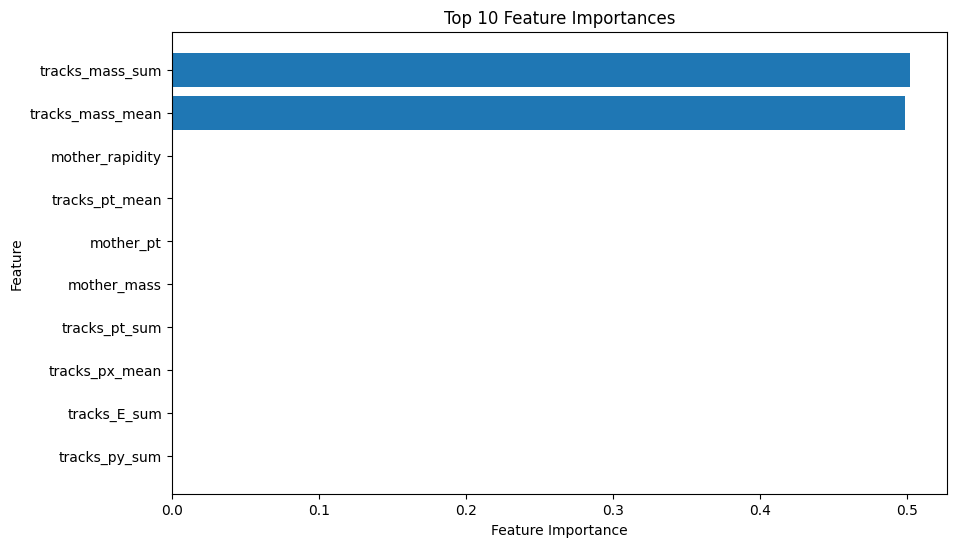

In [59]:
def plot_feature_importances(model, feature_names, num_features=10):
    """
    Plots the top N most important features from the trained Gradient Boosting model.

    Parameters:
    model (GradientBoostingClassifier): The trained model.
    feature_names (list): List of feature names corresponding to the model input features.
    num_features (int): Number of top features to plot (default is 10).
    """
    # Get feature importances from the model
    importances = model.feature_importances_
    
    # Get indices of the sorted importances
    indices = np.argsort(importances)[::-1][:num_features]
    
    # Sort the feature names by importance
    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]
    
    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top {} Feature Importances'.format(num_features))
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

# Example usage:

# Assuming `model` is your trained Gradient Boosting model and `combined_df_features` is your feature DataFrame
feature_names = combined_df_features.drop(columns=['label']).columns.tolist()
plot_feature_importances(model, feature_names, num_features=10)
